In [1]:
%reload_ext autoreload
%reload_ext rpy2.ipython

%autoreload 2
%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style('white')

import nbsupport.expression.normalization as nb_norm

def read_tsv(file_path, *args, index_col=0, **kwargs):
    """Helper function to quickly read indexed tsv files."""
    return pd.read_csv(file_path, sep='\t', index_col=index_col)

# Human PAM50 comparison

## Datasets

### Mouse dataset

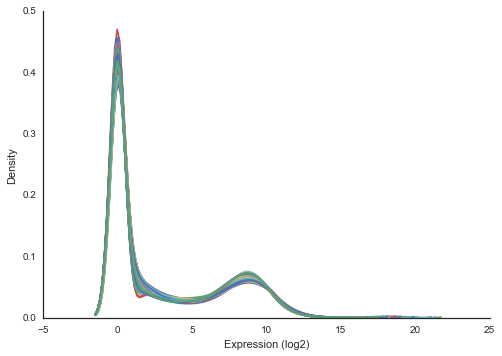

In [2]:
samples = pd.read_csv('../data/raw/samples.txt', sep='\t')

# Read counts.
sb_counts = read_tsv('../data/processed/expression/expression.sb.txt')
sb_counts = sb_counts[samples['sample']]

kb1p_counts = read_tsv('../data/external/mouse-models/expression.kb1p.txt')
pten_counts = read_tsv('../data/external/mouse-models/expression.pten.txt')

# Merge the datasets.
mouse_counts = pd.concat([sb_counts, kb1p_counts, pten_counts], axis=1)
mouse_counts.dropna(inplace=True)

# Normalize for depth and log transform.
mouse_expr = nb_norm.normalize_counts(mouse_counts)
mouse_expr = np.log2(mouse_expr + 1)

# Define mouse design frame.
def _mouse_model(sample):
    if sample in kb1p_counts.columns:
        return 'Basal-like'
    elif sample in pten_counts.columns:
        return 'Luminal'
    else:
        return 'SB'

mouse_design = pd.DataFrame({
    'sample': mouse_expr.columns,
    'mouse_model': [_mouse_model(s) for s in  mouse_expr.columns],
    'organism': 'mouse',
}).set_index('sample')

# Plot distribution of counts for QC.
nb_norm.plot_distribution(mouse_expr);

### TCGA dataset

In [ ]:
# Read and log transform counts.
tcga_expr = pd.read_csv('../data/external/tcga-expression.normalized.txt',
                        sep='\t', index_col=0)
tcga_expr = np.log2(tcga_expr + 1)
    
# Build human design matrix.
tcga_design = read_tsv('../data/external/tcga-breast-2012/BRCA.547.PAM50.SigClust.Subtypes.txt')[['PAM50']]
tcga_design.rename(columns=dict(PAM50='subtype'), inplace=True)
tcga_design['organism'] = 'human'

# Convert PAM50 to (ordered) categorical.
pam50_order = ['LumA', 'LumB', 'Her2', 'Basal', 'Normal']
tcga_design['subtype'] = pd.Categorical(tcga_design['subtype'], categories=pam50_order)

# Subset to common samples.
common_samples = list(set(tcga_expr.columns) & set(tcga_design.index))

tcga_expr = tcga_expr[common_samples]
tcga_design = tcga_design.ix[common_samples]

# QC plot.
nb_norm.plot_distribution(tcga_expr);

### Combined human/mouse dataset

In [4]:
import genemap

# Map TCGA expression to mouse symbols.
tcga_expr_mm = genemap.map_frame(
    tcga_expr, from_type='symbol', to_type='symbol',
    from_organism='hsapiens', to_organism='mmusculus', mapper='ensembl')

# Combine mouse and human datasets.
combined_expr = pd.concat([mouse_expr, tcga_expr_mm], axis=1).dropna()
combined_design = pd.concat([mouse_design, tcga_design], axis=0)

## Hierarchical clustering

In [5]:
import genemap

# Read list of pam50 genes.
with open('../data/external/tcga-breast-2012/pam50_genes.txt') as file_:
    pam50_human = [line.strip() for line in file_]
    
# Map to mouse symbols.
pam50_mouse = genemap.map_ids(
    pam50_human, from_type='symbol', to_type='symbol',
    from_organism='hsapiens', to_organism='mmusculus', mapper='ensembl')
pam50_mouse = [gene for gene in pam50_mouse if gene is not None]

print('Missing genes: {}'.format(len(pam50_human) - len(pam50_mouse)))

Missing genes: 4


Found
 
2
 
batches

Adjusting for
 
0
 
covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data



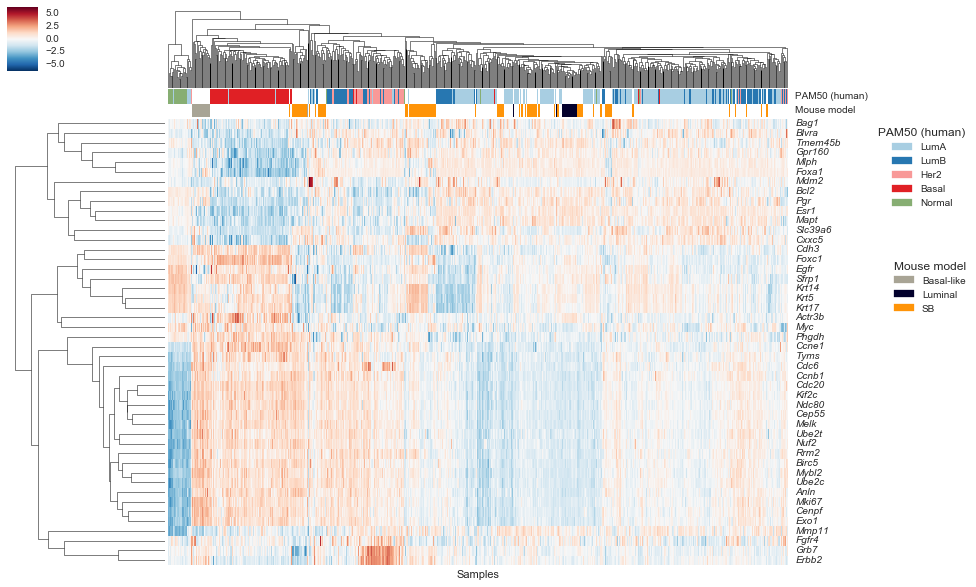

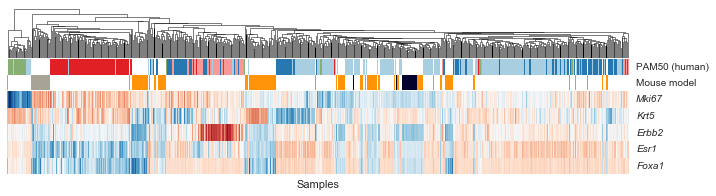

In [6]:
from nbsupport.expression import util as nb_expr_util
from nbsupport.util import color_annotation


# Perform batch correction with ComBat.
combined_expr_combat = nb_norm.combat(
    combined_expr, batch=combined_design['organism'])

# Prepare annotation.
pam50_order = ['LumA', 'LumB', 'Her2', 'Basal', 'Normal']
model_order = ['Basal-like', 'Luminal', 'SB']

combined_annotation = (
    combined_design
    .assign(mouse_model=lambda df: pd.Categorical(df['mouse_model'], categories=model_order),
            subtype=lambda df: pd.Categorical(df['subtype'], categories=pam50_order))
    .rename(columns={'subtype': 'PAM50 (human)', 'mouse_model': 'Mouse model'})
    .get(['PAM50 (human)', 'Mouse model']))

# Color annotation.
model_palette = sns.color_palette(sns.xkcd_palette(['greyish', 'midnight', 'tangerine']))
pam50_palette = sns.color_palette(['#a8cee2', '#2777b1', '#f89998', '#e02025', '#87ae73'])

colored_annotation, annotation_cmaps = color_annotation(
    combined_annotation, colors=[pam50_palette, model_palette])

# Calculate column clustering.
col_linkage = nb_expr_util.calc_linkage(
    combined_expr_combat.ix[pam50_mouse],
    z_score=0, metric='euclidean', method='average')

nb_expr_util.clustermap(
    combined_expr_combat.ix[pam50_mouse], z_score=0, col_linkage=col_linkage,
    method='complete', col_colors=colored_annotation, figsize=(14, 10),
    legend_cmaps=[annotation_cmaps], legend_kws={'position': (1.3, 1), 'offset': 0.3})

# Plot 'zoomed' clustering.
zoom_genes = ['Mki67', 'Krt5', 'Erbb2', 'Esr1', 'Foxa1']
nb_expr_util.clustermap(
    combined_expr.ix[zoom_genes], z_score=0, col_linkage=col_linkage,
    method='complete', col_colors=colored_annotation, figsize=(14, 3),
    col_ratios={'side_colors': 0.3, 'dendrogram': 0.5},
    row_cluster=False, colorbar=False)

In [7]:
with sns.plotting_context('paper', font_scale=0.7):
    # Plot full clustering.
    cm = nb_expr_util.clustermap(
        combined_expr_combat.ix[pam50_mouse], z_score=0, col_linkage=col_linkage,
        method='complete', col_colors=colored_annotation, figsize=(7, 5),
        legend_cmaps=[annotation_cmaps], legend_kws={'position': (1.3, 1), 'offset': 0.3})
    cm.savefig('../reports/supplemental/figures/fig_s2_pam50_tgca.pdf', bbox_inches='tight')
    
    plt.close(cm.fig)
    
    # Plot 'zoomed' clustering.
    zoom_genes = ['Mki67', 'Krt5', 'Erbb2', 'Esr1', 'Foxa1']
    cm = nb_expr_util.clustermap(
        combined_expr.ix[zoom_genes], z_score=0, col_linkage=col_linkage,
        method='complete', col_colors=colored_annotation, figsize=(11, 2),
        col_ratios={'side_colors': 0.3, 'dendrogram': 0.5},
        row_cluster=False, colorbar=False)
    
    cm.savefig('../reports/figures/fig_2_pam50_zoom.pdf', bbox_inches='tight')
    
    plt.close(cm.fig)

# Subtype analysis

## NMF factorization

In [8]:
sb_expr = nb_norm.normalize_counts(sb_counts)
sb_expr = np.log2(sb_expr + 1)

       [,1]        [,2]        [,3]        [,4]       
Rowv   List,2      List,2      List,2      List,2     
rowInd Integer,123 Integer,123 Integer,123 Integer,123
Colv   List,2      List,2      List,2      List,2     
colInd Integer,123 Integer,123 Integer,123 Integer,123
quartz_off_screen 
                2 


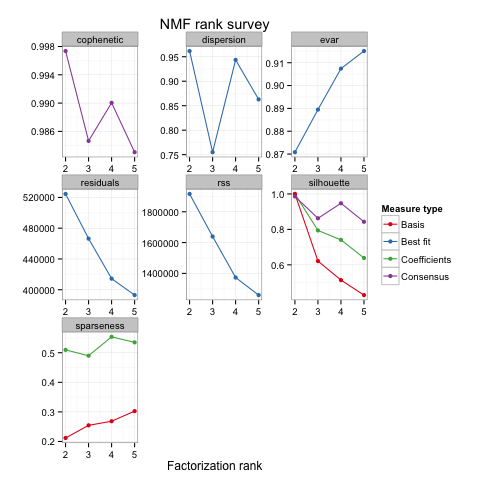

In [9]:
%%R -i sb_counts,sb_expr

suppressMessages({
    library(readr)
    library(NMF)
})


interim_dir = '../data/interim/nmf'

# Create directory if it doesn't exist.
if (!dir.exists(interim_dir)) {
    dir.create(interim_dir, recursive=TRUE)
}

rank_path = file.path(interim_dir, 'rank_estimation.rds')
factorization_path = file.path(interim_dir, 'factorization.rds')

# Check if computation needs to be done.
if (!file.exists(rank_path) | !file.exists(factorization_path)) {
    # Mask any genes with too little counts or no variance.
    expr = sb_expr[(apply(sb_counts >= 10, 1, sum) >= 2) &
                   (apply(sb_counts, 1, var) > 1e-10), ]

    # Base all counts at zero.
    expr = expr - apply(expr, 1, min)
    
    if (!file.exists(rank_path)) {
        # Perform rank estimation.
        estimated_rank = nmf(as.matrix(expr), 
                             rank=2:5, nrun=30, .pbackend=4) 
        saveRDS(estimated_rank, file=rank_path)
    }
    
    if (!file.exists(factorization_path)) {
        # Do the actual factorization with 4 clusters.
        nmf4 = nmf(expr, rank=4, nrun=200, .pbackend=4) 
        saveRDS(nmf4, file=factorization_path)
    }
}

# Plot results of rank estimation.
estimated_rank = readRDS(rank_path)
print(plot(estimated_rank))

# Plot for paper.
pdf(file='../reports/supplemental/figures/fig_s11_nmf_est.pdf',
    width=12, height=7)
print(plot(estimated_rank))
dev.off()

# Also plot consensusmap.
pdf(file='../reports/supplemental/figures/fig_s11_nmf_consensus.pdf',
    width=12, height=7)
print(consensusmap(estimated_rank))
dev.off()

In [29]:
%%R 

processed_dir = '../data/processed/nmf'

# Create directory if it doesn't exist.
if (!dir.exists(processed_dir)) {
    dir.create(processed_dir, recursive=TRUE)
}

# Extract results of factorization.
nmf4 = readRDS(factorization_path)

nmf4_coef = t(as.data.frame(coef(nmf4)))
colnames(nmf4_coef) = c(1, 2, 3, 4)

write.table(nmf4_coef, file='../data/processed/nmf/coefficients.txt',
            sep='\t', row.names=TRUE, quote=FALSE)

# Extract features/genes.
nmf4_features = extractFeatures(nmf4)
nmf4_genes = do.call('rbind', 
    lapply(seq_along(nmf4_features), function(i) {
        gene_symbols = rownames(nmf4)[nmf4_features[[i]]] 
        data.frame(cluster=i, gene_symbol=gene_symbols)
    })
)

write.table(nmf4_genes, file='../data/processed/nmf/genes.txt',
            sep='\t', row.names=FALSE, quote=FALSE)

Found 2 batches
Adjusting for 0 covariate(s) or covariate level(s)
Standardizing Data across genes
Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data


## Naming the subtypes

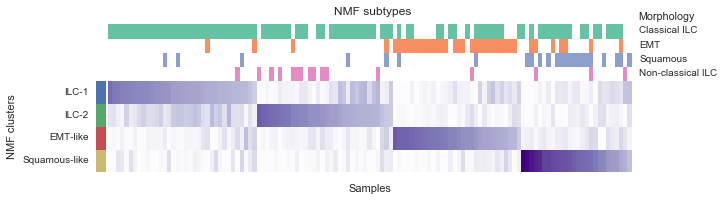

In [30]:
import re

from nbsupport.expression import subtypes as nb_subtypes
from nbsupport.util import color_annotation

# Fetch coefficients.

#def fix_r_rename(values):
#    return [re.sub('^X', '', v).replace('.', '-') for v in values]

nmf_coef = pd.read_csv('../data/processed/nmf/coefficients.txt', sep='\t', index_col=0)
#nmf_coef.index = fix_r_rename(nmf_coef.index)

# Read and color morphology annotation.
morphology = pd.read_csv('../data/processed/morphology.txt', sep='\t', index_col=0)
morphology_colors = color_annotation(morphology, colors=sns.color_palette('Set2'))[0]

# Assign colors/names to the samples.
subtype_names = ['ILC-2', 'ILC-1', 'Squamous-like', 'EMT-like']
subtype_order = ['ILC-1', 'ILC-2', 'EMT-like', 'Squamous-like']
subtype_colors = [sns.color_palette()[i] for i in list(range(3)) + [4]]

# Plot coefficient map.
def _plot_coefficient_map(figsize=(14, 4), font_scale=1.0,
                          morphology_offset=(0.907, 0.83)):
    cm = nb_subtypes.plot_nmf_coefficients(
        nmf_coef, sort=True, figsize=figsize, # colorbar=False,
        names=subtype_names, order=subtype_order,
        col_colors=morphology_colors, col_ratios=dict(side_colors=0.5),
        row_colors=subtype_colors, row_ratios=dict(side_colors=0.015),
        cmap='Purples', colorbar=False)

    cm.ax_heatmap.set_xlabel('Samples')
    cm.ax_row_colors.set_ylabel('NMF clusters')

    cm.ax_row_colors.set_yticks(np.arange(3.5, 0, -1))
    cm.ax_row_colors.set_yticklabels(subtype_order)

    cm.ax_heatmap.set_yticks([])

    cm.fig.text(*morphology_offset, s='Morphology', rotation=0, fontsize=9 * font_scale)
    cm.fig.text(x=0.6, y=0.85, s='NMF subtypes', rotation=0, ha='center')
    
    return cm

_plot_coefficient_map(figsize=(12, 3), font_scale=1.2);

In [31]:
with sns.plotting_context('paper', font_scale=0.7):
    cm = _plot_coefficient_map(figsize=(9.8, 1.5), font_scale=0.7)
    cm.savefig('../reports/figures/fig_2_nmf_coef.pdf', bbox_inches='tight')
    plt.close(cm.fig)

In [32]:
from IPython.display import display
from nbsupport.enrichment import associations as nb_assoc

# Assign samples to (putatively named) subtypes.
nmf_subtypes = nb_subtypes.nmf_assign_clusters(nmf_coef)

subtype_map = dict(zip(['1', '2', '3', '4'], subtype_names))
nmf_subtypes['subtype'] = nmf_subtypes['cluster'].map(subtype_map)

# Test enrichment with morphology.
result = nb_assoc.test_associations(
    nmf_subtypes[['subtype']],
    morphology, alternative='greater')

print('Subtypes')
display(result.query('p_value_corr < 0.05'))

# Test enrichment with merged ILC clusters.
merge_map = {'ILC-1': 'ILC', 'ILC-2': 'ILC'}
nmf_subtypes['subtype_merged'] = nmf_subtypes['subtype'].map(
    lambda s: merge_map.get(s, s))

result_merged = nb_assoc.test_associations(
    nmf_subtypes[['subtype_merged']],
    morphology, alternative='greater')

print('Merged ILC subtypes')
display(result_merged.query('p_value_corr < 0.05'));

Subtypes


,a,b,p_value,p_value_corr
1,subtype_EMT-like,EMT,3.045401e-15,4.872641e-14
4,subtype_ILC-1,Classical ILC,1.895761e-05,1.011073e-04
11,subtype_ILC-2,Non-classical ILC,1.404535e-04,5.618138e-04
14,subtype_Squamous-like,Squamous,1.989157e-09,1.591325e-08


Merged ILC subtypes


,a,b,p_value,p_value_corr
1,subtype_merged_EMT-like,EMT,3.045401e-15,3.654481e-14
4,subtype_merged_ILC,Classical ILC,6.431308e-05,2.572523e-04
10,subtype_merged_Squamous-like,Squamous,1.989157e-09,1.193494e-08


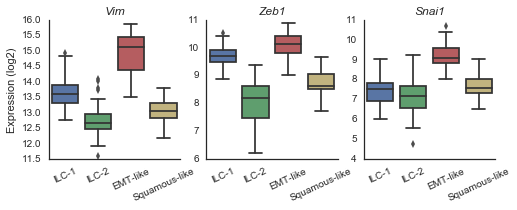

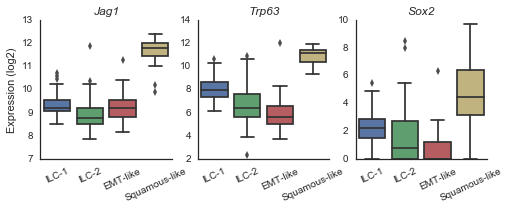

In [33]:
sb_expr_with_subtypes = pd.concat([sb_expr.T, nmf_subtypes['subtype']], axis=1)

# Plot EMT gene expression.
emt_genes = ['Vim', 'Zeb1', 'Snai1', 'Krt5']

fig, axes = plt.subplots(figsize=(8, 2.5), ncols=3)
nb_subtypes.plot_gene_boxplots(
    sb_expr_with_subtypes, genes=emt_genes,
    cluster='subtype', axes=axes.flatten(),
    order=subtype_order, palette=subtype_colors)
axes[0].set_ylabel('Expression (log2)')

# Plot Squamous gene expression.
squamous_genes = ['Jag1', 'Trp63', 'Sox2']

fig, axes = plt.subplots(figsize=(8, 2.5), ncols=3)
nb_subtypes.plot_gene_boxplots(
    sb_expr_with_subtypes, genes=squamous_genes,
    cluster='subtype', axes=axes.flatten(),
    order=subtype_order, palette=subtype_colors)
axes[0].set_ylabel('Expression (log2)');

In [34]:
with sns.plotting_context('paper', font_scale=0.7):
    # Plot EMT gene expression.
    fig, axes = plt.subplots(figsize=(3.8, 1.1), ncols=3)
    nb_subtypes.plot_gene_boxplots(
        sb_expr_with_subtypes, genes=emt_genes,
        cluster='subtype', axes=axes.flatten(),
        order=subtype_order, palette=subtype_colors)
    axes[0].set_ylabel('Expression (log2)')
    fig.suptitle('EMT marker genes', y=1.15, fontsize=7)
    fig.savefig('../reports/supplemental/figures/fig_s2_emt_genes.pdf',
                bbox_inches='tight')
    
    plt.close(fig)

    # Plot Squamous gene expression.
    fig, axes = plt.subplots(figsize=(3.8, 1.1), ncols=3)
    nb_subtypes.plot_gene_boxplots(
        sb_expr_with_subtypes, genes=squamous_genes,
        cluster='subtype', axes=axes.flatten(),
        order=subtype_order, palette=subtype_colors)
    axes[0].set_ylabel('Expression (log2)');
    fig.suptitle('Squamous marker genes', y=1.15, fontsize=7)
    fig.savefig('../reports/supplemental/figures/fig_s2_squamous_genes.pdf',
                bbox_inches='tight')
    
    plt.close(fig)

In [35]:
# Write subtypes for use in other notebooks.
nmf_subtypes.to_csv('../data/processed/nmf/subtypes.txt', sep='\t', index=True)

## PAM50 expression across subtypes

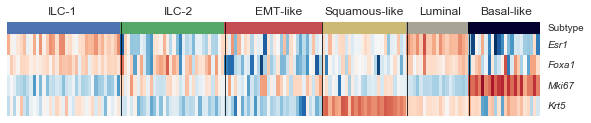

In [36]:
# Combine expression with subtypes.
mouse_subtypes = pd.concat([mouse_design, nmf_subtypes['subtype']], axis=1)
mouse_subtypes.ix[mouse_subtypes['mouse_model'] == 'Basal-like', 'subtype'] = 'Basal-like'
mouse_subtypes.ix[mouse_subtypes['mouse_model'] == 'Luminal', 'subtype'] = 'Luminal'

mouse_expr_with_subtypes = pd.concat([mouse_expr.T, mouse_subtypes[['subtype']]], axis=1)

# Plot heatmap.
selected_pam50_genes = ['Esr1', 'Foxa1', 'Mki67', 'Krt5']

mouse_order = ['Luminal', 'Basal-like']
mouse_colors = sns.color_palette(sns.xkcd_palette(['greyish', 'midnight']))

combined_order = subtype_order + mouse_order
combined_colors = subtype_colors + mouse_colors

cm = nb_subtypes.plot_gene_heatmap(
    mouse_expr_with_subtypes, genes=selected_pam50_genes,
    cluster='subtype', figsize=(12, 2), col_cluster=False,
    order=combined_order, palette=combined_colors,
    col_ratios={'side_colors': 0.12}, colorbar=False)

cm.fig.text(x=0.33, y=0.83, s='ILC-1')
cm.fig.text(x=0.465, y=0.83, s='ILC-2')
cm.fig.text(x=0.57, y=0.83, s='EMT-like')
cm.fig.text(x=0.65, y=0.83, s='Squamous-like')
cm.fig.text(x=0.760, y=0.83, s='Luminal')
cm.fig.text(x=0.830, y=0.83, s='Basal-like')

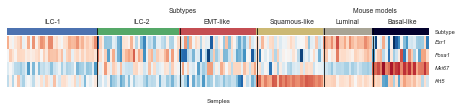

In [37]:
with sns.plotting_context('paper', font_scale=0.7):
    cm = nb_subtypes.plot_gene_heatmap(
        mouse_expr_with_subtypes, genes=selected_pam50_genes,
        cluster='subtype', figsize=(9.5, 1.3), col_cluster=False,
        order=combined_order, palette=combined_colors,
        col_ratios={'side_colors': 0.12}, colorbar=False)
    
    cm.ax_heatmap.set_xlabel('Samples')

    cm.fig.text(x=0.35, y=0.81, s='ILC-1', ha='center')
    cm.fig.text(x=0.48, y=0.81, s='ILC-2', ha='center')
    cm.fig.text(x=0.59, y=0.81, s='EMT-like', ha='center')
    cm.fig.text(x=0.7, y=0.81, s='Squamous-like', ha='center')
    cm.fig.text(x=0.78, y=0.81, s='Luminal', ha='center')
    cm.fig.text(x=0.86, y=0.81, s='Basal-like', ha='center')
    
    cm.fig.text(x=0.54, y=0.93, s='Subtypes', ha='center')
    cm.fig.text(x=0.82, y=0.93, s='Mouse models', ha='center')
    
    cm.savefig('../reports/figures/fig_2_pam50_heatmap.pdf', bbox_inches='tight')

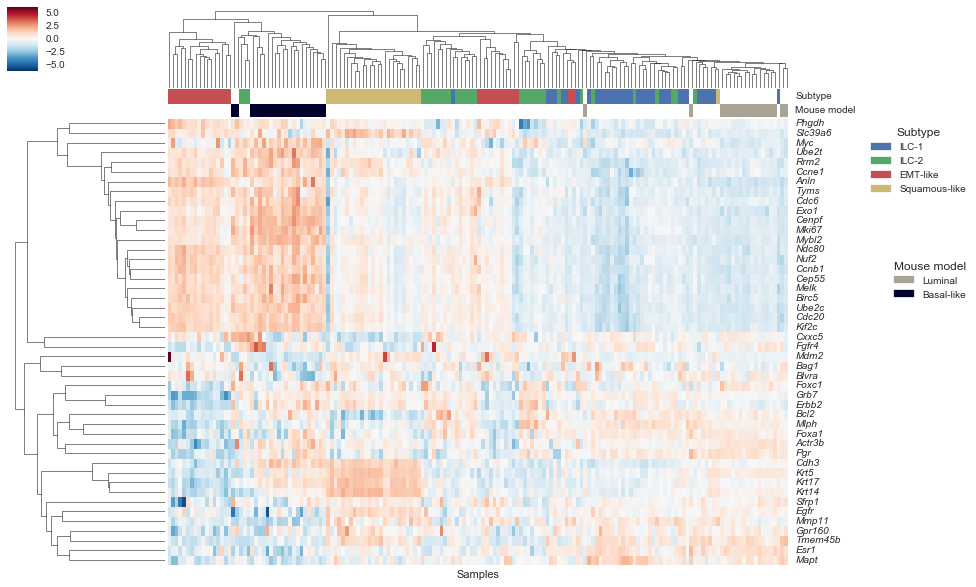

In [38]:
mouse_subtypes2 = (
    pd.concat([
        (nmf_subtypes['subtype'].astype('category', categories=subtype_order)),
        (mouse_design['mouse_model']
             .replace('SB', np.nan)
             .astype('category', categories=mouse_order))
    ], axis=1)
    .rename(columns=lambda c: c.replace('_', ' ').capitalize()))

mouse_annotation, mouse_cmaps = color_annotation(
    mouse_subtypes2, [subtype_colors, mouse_colors])

nb_expr_util.clustermap(
    mouse_expr.ix[pam50_mouse], z_score=0, 
    method='average', col_colors=mouse_annotation, figsize=(14, 10),
    legend_cmaps=[mouse_cmaps], legend_kws={'position': (1.3, 1), 'offset': 0.3})

In [39]:
with sns.plotting_context('paper', font_scale=0.7):
    cm = nb_expr_util.clustermap(
        mouse_expr.ix[pam50_mouse], z_score=0, 
        method='average', col_colors=mouse_annotation, figsize=(7, 5),
        legend_cmaps=[mouse_cmaps], legend_kws={'position': (1.3, 1), 'offset': 0.3})
    cm.savefig('../reports/supplemental/figures/fig_s2_pam50_mouse.pdf', bbox_inches='tight')
    plt.close(cm.fig)

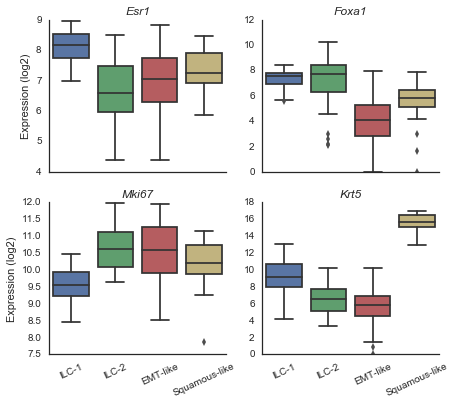

In [40]:
# Draw again as boxplot.
selected_pam50_genes = ['Esr1', 'Foxa1', 'Mki67', 'Krt5']

fig, axes = plt.subplots(figsize=(7, 6), sharex=True,
                         ncols=2, nrows=2)

nb_subtypes.plot_gene_boxplots(
    mouse_expr_with_subtypes, genes=selected_pam50_genes,
    cluster='subtype', axes=axes.flatten(),
    order=subtype_order, palette=subtype_colors)

for row in axes:
    row[0].set_ylabel('Expression (log2)')

In [41]:
with sns.plotting_context('paper', font_scale=0.7):
    fig, axes = plt.subplots(figsize=(3.4, 3), sharex=True,
                             ncols=2, nrows=2)

    nb_subtypes.plot_gene_boxplots(
        mouse_expr_with_subtypes, genes=selected_pam50_genes,
        cluster='subtype', axes=axes.flatten(),
        order=subtype_order, palette=subtype_colors)

    for row in axes:
        row[0].set_ylabel('Expression (log2)')
        
    fig.savefig('../reports/figures/fig_2_pam50_mouse_boxplot.pdf',
                bbox_inches='tight')
    
    plt.close(fig)

## Comparison with human subtypes

In [42]:
import genemap

# Read 60-gene signature and translate to mouse.
signature = (pd.read_excel('../data/external/tcga-ilc-2015/mmc9.xlsx', skiprows=2)
               .get('ILC 60 Gene Classifier').dropna()
               .map(lambda s: s.split('|')[0])
               .pipe(list))

signature_mouse = genemap.map_ids(
    signature, from_type='symbol', to_type='symbol',
    from_organism='hsapiens', to_organism='mmusculus', mapper='ensembl')

signature_mouse = list(filter(bool, signature_mouse))

In [43]:
# Read tcga expression and subtypes.
tcga_ilc_path = '../data/external/tcga-ilc-2015/ILC_rnaseqv2_RSEM_genes_normalized_data_F2.txt'
subtype_path = '../data/external/tcga-ilc-2015/mmc9.xlsx'

tcga_ilc_expr = (pd.read_csv(tcga_ilc_path, sep='\t', index_col=0)
                   .drop('?').drop('Unnamed: 128', axis=1)
                   .pipe(lambda df: np.log2(df + 1)))

tcga_subtypes = (pd.read_excel(subtype_path, skiprows=3)
                   .get(['Sample ID', 'Dataset', '60 Gene-classifier Class Assignment'])
                   .rename(columns={'Sample ID': 'sample', 'Dataset': 'dataset',
                                    '60 Gene-classifier Class Assignment': 'subtype'})
                   .assign(sample=lambda df: df['sample'].str.replace('.', '-'))
                   .dropna()
                   .query('dataset == "TCGA"')
                   .set_index('sample', drop=False))

# Map to mouse symbols and combine.
tcga_ilc_expr_mm = genemap.map_frame(
    tcga_ilc_expr, from_type='symbol', to_type='symbol',
    from_organism='hsapiens', to_organism='mmusculus', mapper='ensembl')

combined_ilc_expr = pd.concat(
    [sb_expr.ix[signature_mouse], 
     tcga_ilc_expr_mm.ix[signature_mouse]], axis=1)

# Normalize using ComBat.
combat_ilc_design = (
    pd.concat(
        [pd.DataFrame({'sample': tcga_ilc_expr_mm.columns, 'organism': 'human'}),
         pd.DataFrame({'sample': sb_expr.columns, 'organism': 'mouse'})])
    .get(['sample', 'organism']))

combat_ilc_expr = nb_norm.combat(combined_ilc_expr, batch=combat_ilc_design['organism'])

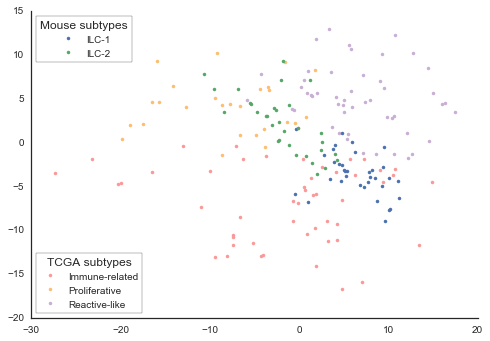

In [44]:
from sklearn.decomposition import PCA

# Fit PCA.
pca = PCA(n_components=2)
pca.fit(combat_ilc_expr.ix[signature_mouse].T)

# Apply to samples.
x_transform = pd.DataFrame(
    pca.transform(combat_ilc_expr.ix[signature_mouse].T),
    index=combat_ilc_expr.columns)

# Annotate transformation.
merged_subtypes = pd.concat([nmf_subtypes[['subtype']].assign(type='mouse'), 
                             tcga_subtypes[['subtype']].assign(type='human')])
x_transform = pd.concat([x_transform, merged_subtypes], axis=1)


def _plot_pca(ax=None):
    # Setup figure.
    if ax is None:
        _, ax = plt.subplots()

    # Plot tcga samples.
    paired_colors = sns.color_palette('Paired', 12)
    tcga_colors = [paired_colors[i] for i in [4, 6, 8]]

    tcga_labels = ['Immune-related', 'Proliferative', 'Reactive-like']

    for subtype, color in zip(tcga_labels, tcga_colors):
        grp = x_transform.ix[x_transform['subtype'] == subtype]
        ax.plot(grp[0], grp[1], '.', color=color, label=subtype)

    legend = ax.legend(loc='lower left', frameon=True, title='TCGA subtypes')
    ax.add_artist(legend)

    # Plot mouse samples.
    handles = []
    for subtype, color in zip(subtype_order[:2], subtype_colors):
        grp = x_transform.ix[x_transform['subtype'] == subtype]
        lines = ax.plot(grp[0], grp[1], '.', color=color, label=subtype)
        handles.append(lines[0])

    ax.legend(loc='upper left', handles=handles, frameon=True, title='Mouse subtypes')
    sns.despine()
    
_plot_pca()

with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(5, 3))
    _plot_pca(ax=ax)
    ax.set_title('PCA of human (TCGA) and mouse ILC subtypes')
    fig.savefig('../reports/figures/fig_2_human_subtypes.pdf', bbox_inches='tight')
    plt.close(fig)